In [9]:
# -------------------------------
# Prerequisite for most tutorials
# -------------------------------

# Here are a few helpers and dependencies that may be required by some tutorials:

%matplotlib inline
import os.path
from math import *
import numpy as np
from tramway.helper import *
from tramway.helper.simulation import *
import matplotlib.pylab as plt

trajectory_file = 'trajectories.txt'
rwa_file = 'trajectories.rwa'

trajectories_with_time_varying_properties = 'trajectories2.txt'
analyses_with_time_varying_properties = 'trajectories2.rwa'

def load_default_trajectories(time_varying_properties=False):
    if time_varying_properties:
        # trajectories2.txt
        if os.path.exists(trajectories_with_time_varying_properties):
            xyt = load_xyt(trajectories_with_time_varying_properties)
        else:
            x0 = y0 = 0.
            width = height = 1.
            duration = 5. # minimum duration of the simulation in s
            tau = .2 # trajectory lifetime in s
            D = .1 # diffusivity in um2.s-1
            dV = 10 # maximum force amplitude in kB.T(?)
            v_area_center= np.array([x0+width/2, y0+height/2, duration/2])
            v_area_radius = .2
            sigma = 1. / sqrt(-log(.05))
            time_factor = max(width, height) / duration *.8
            def F(r, t):
                f = r - v_area_center[:2]
                r2 = np.dot(f, f) + (time_factor * (t - v_area_center[2])) ** 2
                s2 = (v_area_radius * sigma) ** 2
                f *= -2. * dV / s2 * exp(-r2/s2)
                return f
            xyt = random_walk(diffusivity=D,
                force=F,
                lifetime_tau=tau,
                box=(x0, y0, x0+width, y0+height),
                duration=duration,
                minor_step_count=999,
                full=True,
                )
            t0 = .05 # dt
            xyt = xyt[xyt['t']<t0+duration]
            xyt.to_csv(trajectories_with_time_varying_properties, sep='\t', header=False)
        return xyt
    
    else:
        # trajectories.txt
        if os.path.exists(trajectory_file):
            xyt = load_xyt(trajectory_file)
        else:
            dt = .05 # time step in s
            tau = .25 # trajectory lifetime in s
            D = .1 # diffusivity in um2.s-1
            F = 2 # force amplitude in kB.T
            xyt = random_walk_2d(
                n_trajs=400, N_mean=tau/dt, dt=dt,
                D0=D, amplitude_D=0,
                amplitude_V=-F, mode_V='potential_linear',
                )
            xyt.to_csv(trajectory_file, sep='\t', header=False)
        return xyt

def load_default_partition(time_varying_properties=False):
    if time_varying_properties:
        # trajectories2.rwa
        if os.path.exists(analyses_with_time_varying_properties):
            analysis_tree = load_rwa(analyses_with_time_varying_properties, lazy=True)
        else:
            analysis_tree = Analyses(load_default_trajectories(time_varying_properties=True))
        if 'default' in analysis_tree.labels:
            cells = analysis_tree['default'].data
        else:
            cells = tessellate(analysis_tree, 'hexagon',
                lower_bound=np.array((-.1,-.1)), upper_bound=np.array((1.1,1.1)),
                time_window_duration=1., time_window_shift=1.,
                time_window_options=dict(time_dimension=True),
                knn=10,
                output_label='default')
            save_rwa(analyses_with_time_varying_properties, analysis_tree, force=True)
        return cells
    
    else:
        # trajectories.rwa
        if os.path.exists(rwa_file):
            analysis_tree = load_rwa(rwa_file, lazy=True)
        else:
            analysis_tree = Analyses(load_default_trajectories())
        if 'default' in analysis_tree.labels:
            cells = analysis_tree['default'].data
        else:
            cells = tessellate(analysis_tree, 'hexagon',
                lower_bound=np.array((-.6,-.6)), upper_bound=np.array((.6,.6)),
                output_label='default')
            save_rwa(rwa_file, analysis_tree, force=True)
        return cells

def load_default_maps(_and_partition=False):
    if os.path.exists(rwa_file):
        analysis_tree = load_rwa(rwa_file, lazy=True)
        if 'default' not in analysis_tree.labels:
            raise NotImplementedError('please run load_default_partition or delete the {} file'.format(rwa_file))
        if _and_partition:
            cells = analysis_tree['default'].data
    else:
        cells = load_default_partition()
        analysis_tree = Analyses(cells.points)
        analysis_tree.add(cells, label='default')
    default_subtree = analysis_tree['default']
    if 'default' not in default_subtree.labels:
        infer(analysis_tree, 'DV', localization_error=.01, input_label='default', output_label='default')
        save_rwa(rwa_file, analysis_tree, force=True)
    maps = default_subtree['default'].data
    if _and_partition:
        return maps, cells
    else:
        return maps
    
def load_default_tree(time_varying_properties=False):
    if time_varying_properties:
        _file = analyses_with_time_varying_properties
    else:
        _file = rwa_file
    if not os.path.exists(rwa_file):
        load_default_partition(time_varying_properties=time_varying_properties)
    return load_rwa(rwa_file, lazy=True)


0.5


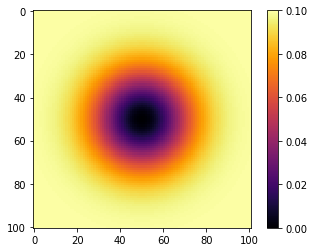

In [112]:
def D_field_array(r,t):
    mu_r=np.array([0.5,0.5])
    sig_r=0.05
    mu_t=0.5
    sig_t=0.05
    D_=0.1
    return D_*(1.-1.*np.exp(-np.sum((r/10.-mu_r)**2,axis=2)/sig_r)) #*np.exp(-(t-mu_t)**2/(sig_t))

def D_field(r,t):
    mu_r=np.array([0.5,0.5])
    sig_r=0.05
    mu_t=0.5
    sig_t=0.05
    D_=0.1
    return D_*(1.-1.*np.exp(-np.sum((r/10.-mu_r)**2)/sig_r)) #*np.exp(-(t-mu_t)**2/(sig_t))

M=100
x = np.arange(0,1.+1./M,1./M)*10.
r = np.zeros([M+1,M+1,2])
for i,y_ in enumerate(x):
    r[i] = np.transpose(np.stack([y_*np.ones(M+1),x]))
for t in [0.5]:
    print(t)
    plt.figure()
    plt.imshow(D_field_array(r,t),clim=[0.,.1],cmap='inferno')
    plt.colorbar()

In [113]:
# --------------------------------------------------------
# Generating molecule trajectories with a diffusivity sink
# --------------------------------------------------------

## key parameters
# number of trajectories
M = 100
# time step in s
dt = 0.05
# Simulation duration:
T = 1.
# average trajectory lifetime in s
tau = 0.25
# baseline diffusivity in um2.s-1
D0 = 0.1
# diffusivity at the bottom of the sink
D = 0.05
# positioning noise (optional)
sigma = 0.

## generate the trajectories
xyt = random_walk(diffusivity=D_field, duration=T, lifetime_tau=tau, single=True, reflect=True, 
                  trajectory_mean_count=M, box=[0.,0.,10.,10.], )
# see also:
# help(random_walk_2d)

# xyt is a DataFrame with columns 'x', 'y' (spatial coordinates), 't' (time) and 'n' (trajectory index).
# each row in a molecule location
xyt=xyt.dropna()
positions = xyt.drop('n',axis=1)

In [114]:
number_of_trajectories = max(xyt['n'].dropna())
print(f"number of trajectories: {int(number_of_trajectories)}")
number_of_positions = (len(xyt.index))
print(f"number of positions: {int(number_of_positions)}")
print(f"avg(tau) = {number_of_positions*dt/number_of_trajectories}")
print(f"avg(M) = {number_of_positions*dt/T}")
print(f"[{min(xyt['x'])},{min(xyt['y'])},{max(xyt['x'])},{max(xyt['y'])}]")

number of trajectories: 388
number of positions: 1956
avg(tau) = 0.25206185567010314
avg(M) = 97.80000000000001
[0.0022435628539851926,0.004871654774690908,9.995374030354425,9.995566159306923]


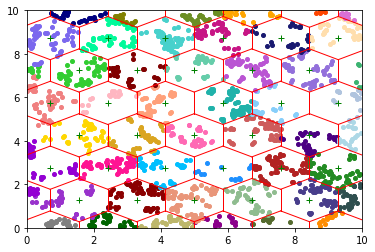

In [115]:
# -------------------------------------------
# tessellating with constant-size space cells
# -------------------------------------------

## key parameters
# average inter-cell distance or cell "diameter" in um
cell_size = 1.

## load the translocation data
#xyt = load_default_trajectories()
# explicit bounds are recommended here with box-less data generation
#lower_bound, upper_bound = np.array((-0.5,-0.5)), np.array((0.5,0.5))

## tessellate
cells = tessellate(xyt, 'hexagon',
        # the inter-cell distance is 2*ref_distance
        ref_distance=cell_size/2,
        # discard the criterion on the minimum number of locations per cell
        min_location_count=10,
#        lower_bound=lower_bound, upper_bound=upper_bound
                  )
# see also command-line help:
# tramway tessellate hexagon -h

## plot
cell_plot(cells)

d mode: elapsed time: 70ms


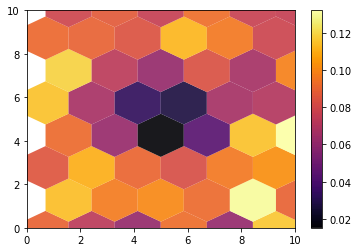

In [116]:
# ------------------------------------------------
# inferring in D mode without spatial regularization
# ------------------------------------------------

## key parameters
# smoothing parameters
D_smoothing = 0.
# localization error in um

## load the partition
#cells = load_default_partition()

## infer
maps = infer(cells, 'D', 
#             diffusivity_prior = D_smoothing,
             localization_error=sigma, verbose=True)

## plot the force
map_plot(maps, cells=cells, title=False, variable='diffusivity',cmap='inferno')
# other variables are 'diffusivity' and 'potential'

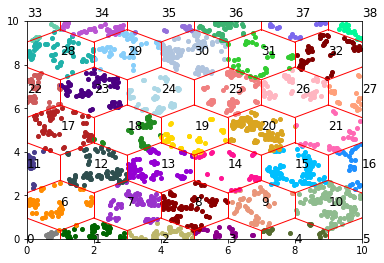

In [134]:
from tramway.helper.tessellation import *
from tramway.helper.inference import *
from tramway.plot.mesh import plot_delaunay
import matplotlib.pyplot as plt
from scipy.stats import skellam
from scipy.optimize import fmin,minimize

tessellation_method = 'hexagon'
mesh_label = '{}'.format(tessellation_method) #, location_count, min_location_count)
#
ref_distance = 1. # [mu]
min_loc_count=0
cells_nt = tessellate(positions, tessellation_method, ref_distance=ref_distance, min_location_count=0,
           strict_min_location_count=min_loc_count,
           force=True, output_label=mesh_label)
# cells_nt = tessellate(positions, 'hexagon',
#         # the inter-cell distance is 2*ref_distance
#         ref_distance=cell_size/2,
#         # discard the criterion on the minimum number of locations per cell
#         min_location_count=10,)

cell_plot(cells_nt, cell_indices=True)

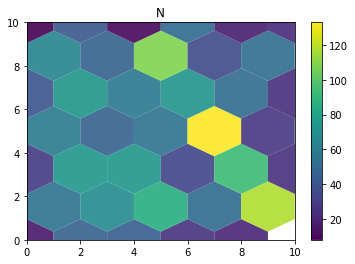

In [135]:
map_plot((pd.DataFrame(cells_nt.location_count, columns=['N'])),cells=cells_nt) #,cmap='inferno') 

In [136]:
p_off = dt/tau
mu_on = p_off
maps_nt = infer(cells_nt, 'nT_test02_hex', new_cell=Locations, dt=0.05, p_off=p_off, mu_on=mu_on,\
        method='NM', tol=1e-3)



S: 0 3.4641016151377544
1 3.4641016151377544
6 6.928203230275509
; total: 10.392304845413264 mu^2
Cell no.: 0 ; sum(N): 16 , possible links: 12 , avg(N): 0.8
Outer cells: sum(N): 100 , possible links: 83 , avg(N): 5.0
All cells: sum(N): 116 , possible links: 98 , avg(N): 5.8
[1, 1, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0]
[10, 10, 10, 8, 7, 4, 4, 4, 4, 4, 5, 4, 3, 5, 4, 6, 7, 7, 4, 6]
 final_simplex: (array([[0.07165773, 0.1177532 ],
       [0.07245781, 0.11731128],
       [0.07263234, 0.11819134]]), array([233.29754595, 233.29760953, 233.29779068]))
           fun: 233.2975459500105
       message: 'Optimization terminated successfully.'
          nfev: 52
           nit: 29
        status: 0
       success: True
             x: array([0.07165773, 0.1177532 ])
D corrected for motion blur and localization error: 0.0324865892529478
104.78062582015991 s

S: 1 3.4641016151377544
0 3.4641016151377544
2 6.928203230275509
6 10.392304845413264
7 13.856406460551018
; total: 17.32

 final_simplex: (array([[0.10748304, 0.10011443],
       [0.10772896, 0.10018925],
       [0.10767242, 0.09977493]]), array([1231.7671358 , 1231.76731953, 1231.76744816]))
           fun: 1231.7671357986203
       message: 'Optimization terminated successfully.'
          nfev: 81
           nit: 41
        status: 0
       success: True
             x: array([0.10748304, 0.10011443])
D corrected for motion blur and localization error: 0.08622456550598068
1967.1130349636078 s

S: 11 3.4641016151377544
6 3.4641016151377544
12 6.928203230275509
17 10.392304845413264
; total: 13.856406460551018 mu^2
Cell no.: 11 ; sum(N): 29 , possible links: 26 , avg(N): 1.45
Outer cells: sum(N): 187 , possible links: 158 , avg(N): 9.35
All cells: sum(N): 216 , possible links: 186 , avg(N): 10.8
[0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 1, 1, 1, 1, 1, 1]
[15, 18, 16, 15, 13, 10, 10, 9, 8, 10, 15, 13, 11, 10, 6, 8, 6, 8, 9, 6]
 final_simplex: (array([[0.08086753, 0.09710257],
       [0.08156089, 0.097322

 final_simplex: (array([[0.01410879, 0.05332963],
       [0.01429593, 0.05328875],
       [0.01414191, 0.05345286]]), array([1955.80065564, 1955.80073665, 1955.80109143]))
           fun: 1955.800655635914
       message: 'Optimization terminated successfully.'
          nfev: 94
           nit: 49
        status: 0
       success: True
             x: array([0.01410879, 0.05332963])
D corrected for motion blur and localization error: 0.0
9547.529865980148 s

S: 20 3.4641016151377544
14 3.4641016151377544
15 6.928203230275509
19 10.392304845413264
21 13.856406460551018
25 17.32050807568877
26 20.784609690826525
; total: 24.248711305964278 mu^2
Cell no.: 20 ; sum(N): 133 , possible links: 122 , avg(N): 6.65
Outer cells: sum(N): 332 , possible links: 295 , avg(N): 16.6
All cells: sum(N): 465 , possible links: 425 , avg(N): 23.25
[5, 6, 7, 7, 7, 8, 9, 9, 10, 8, 7, 7, 7, 8, 7, 6, 6, 4, 3, 2]
[19, 21, 20, 17, 18, 22, 22, 23, 20, 20, 25, 25, 27, 31, 28, 26, 26, 25, 24, 26]
 final_simplex: (a

 final_simplex: (array([[0.12190386, 0.0913782 ],
       [0.12155743, 0.09200386],
       [0.12285786, 0.0919104 ]]), array([1150.92831666, 1150.92894365, 1150.92909832]))
           fun: 1150.92831665863
       message: 'Optimization terminated successfully.'
          nfev: 56
           nit: 29
        status: 0
       success: True
             x: array([0.12190386, 0.0913782 ])
D corrected for motion blur and localization error: 0.10785578593611596
1657.1290957927704 s

S: 29 3.4641016151377544
23 3.4641016151377544
24 6.928203230275509
28 10.392304845413264
30 13.856406460551018
34 17.32050807568877
35 20.784609690826525
; total: 24.248711305964278 mu^2
Cell no.: 29 ; sum(N): 47 , possible links: 37 , avg(N): 2.35
Outer cells: sum(N): 356 , possible links: 326 , avg(N): 17.8
All cells: sum(N): 403 , possible links: 370 , avg(N): 20.15
[2, 2, 3, 2, 2, 3, 3, 1, 2, 2, 4, 3, 3, 2, 2, 1, 1, 2, 3, 4]
[18, 21, 19, 21, 20, 18, 18, 18, 19, 20, 24, 23, 22, 23, 22, 18, 18, 19, 21, 21]
 fina

 final_simplex: (array([[0.06639808, 0.08257542],
       [0.06638448, 0.08258159],
       [0.06641377, 0.08259633]]), array([498.61943363, 498.61943838, 498.61951044]))
           fun: 498.61943362749196
       message: 'Optimization terminated successfully.'
          nfev: 80
           nit: 39
        status: 0
       success: True
             x: array([0.06639808, 0.08257542])
D corrected for motion blur and localization error: 0.024597119358141958
694.3504056930542 s

S: 38 3.4641016151377544
32 3.4641016151377544
37 6.928203230275509
; total: 10.392304845413264 mu^2
Cell no.: 38 ; sum(N): 23 , possible links: 20 , avg(N): 1.15
Outer cells: sum(N): 70 , possible links: 59 , avg(N): 3.5
All cells: sum(N): 93 , possible links: 79 , avg(N): 4.65
[0, 0, 1, 1, 2, 2, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[2, 3, 4, 3, 5, 5, 8, 7, 8, 6, 4, 4, 3, 3, 4, 6, 5, 4, 5, 4]
 final_simplex: (array([[0.08048457, 0.08396005],
       [0.07991783, 0.08446182],
       [0.08038747, 0.08473528]]), a

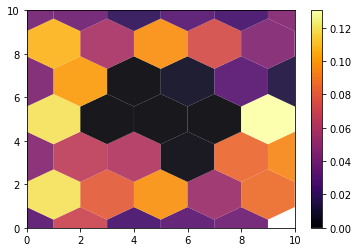

In [137]:
map_plot(maps_nt, cells=cells_nt, title=False, cmap='inferno')
